In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os
import json

print(os.listdir("../input"))
print(os.listdir("../input/imaterialist-fashion-2019-FGVC6"))

['imaterialist-fashion-2019-FGVC6']
['train.csv', 'train', 'label_descriptions.json', 'test', 'sample_submission.csv']


In [2]:
data = pd.read_csv("../input/imaterialist-fashion-2019-FGVC6/train.csv")

In [3]:
data['Category'] = data['ClassId'].apply(lambda x: int(x.split("_")[0]))
data['Attributes'] = data['ClassId'].apply(lambda x: "_".join(x.split("_")[1:]))

In [4]:
img_names = data.ImageId.unique()

In [5]:
train, test, _, _ = train_test_split(img_names, img_names, test_size=0.21, random_state=42)

In [6]:
data['dataset'] = 'train'
data.loc[data['ImageId'].isin(test), 'dataset'] = 'test'

In [7]:
data['Area'] = data.apply(lambda x: sum([int(a) for i, a in enumerate(x['EncodedPixels'].split()) if i % 2 ==1]), axis = 1)

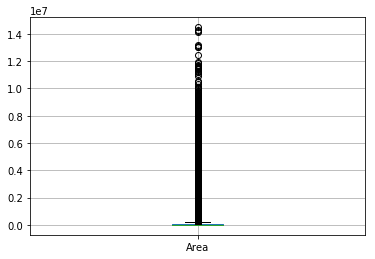

In [8]:
_ = data[data['dataset']=='train'].boxplot(column=['Area'])

In [9]:
print('Min area:', data[data['dataset']=='train'].Area.min())
print('Max area:', data[data['dataset']=='train'].Area.max())

Min area: 1
Max area: 14477438


In [10]:
area_percentile = {}

In [11]:
for i in range(0, int(data[data['dataset']=='train'].Area.quantile(0.75)), 1000):
    area_percentile[i] = data[(data['dataset']=='train')&
                               (data['Area']<=i)].shape[0] / data[data['dataset']=='train'].shape[0]

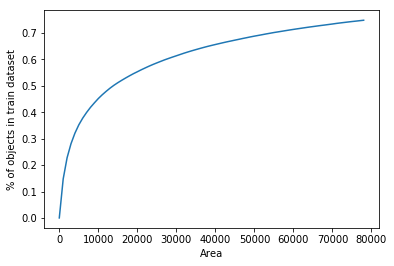

In [12]:
lists = sorted(area_percentile.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel('Area')
plt.ylabel('% of objects in train dataset')
plt.show()

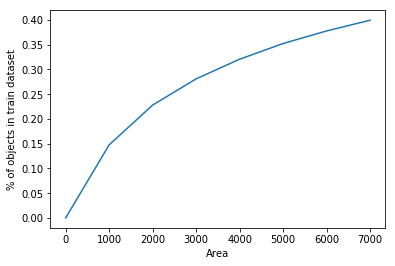

In [13]:
small_lists = [x for x in lists if x[1] < 0.4]

x, y = zip(*small_lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel('Area')
plt.ylabel('% of objects in train dataset')
plt.show()

In [14]:
print('% of objects with area > 10 000')
print(data[(data['dataset']=='train')& (data['Area']>=10000)].shape[0] / data[(data['dataset']=='train')].shape[0])

% of objects with area > 10 000
0.547968977551153


In [15]:
print('Total number of train images:', data[(data['dataset']=='train')].ImageId.nunique())
print('Number of train images with large object on them:', data[(data['dataset']=='train')& (data['Area']>=10000)].ImageId.nunique())
print('Number of train images without atributes:', data[(data['dataset']=='train')&(data['Attributes']=='')].ImageId.nunique())
print('Number of train images with large object on them and without atributes:', data[(data['dataset']=='train')&(data['Area']>=1000)&(data['Attributes']=='')].ImageId.nunique())

Total number of train images: 35704
Number of train images with large object on them: 35631
Number of train images without atributes: 35700
Number of train images with large object on them and without atributes: 35544


In [16]:
print('Total number of objects in train set:', len(data[(data['dataset']=='train')]))
print('Total number of objects in truncated train set:', len(data[(data['dataset']=='train')&(data['Area']>=1000)&(data['Attributes']=='')]))
    

Total number of objects in train set: 261617
Total number of objects in truncated train set: 213997


In [17]:
data_truncated = pd.concat([data[(data['dataset']=='train')&(data['Area']>=1000)&(data['Attributes']=='')],
                               data[data['dataset']=='test']])

In [18]:
print('Nubmer of objects in original dataset: ', len(data))
print('Nubmer of objects in truncated dataset: ', len(data_truncated))


Nubmer of objects in original dataset:  331213
Nubmer of objects in truncated dataset:  283593


In [19]:
data_truncated.to_csv('train_df_truncated.csv', index=False)

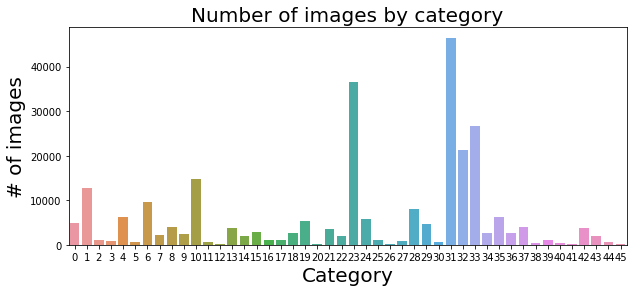

In [20]:
groupby_category = data[(data['dataset']=='train')].groupby('Category')['ImageId'].count()
groupby_category.index = map(int, groupby_category.index)
groupby_category = groupby_category.sort_index()
groupby_category[:5]

fig = plt.figure(figsize=(10, 4))
x = groupby_category.index
y = groupby_category.values

sns.barplot(x,y)
plt.title("Number of images by category", fontsize=20)
plt.xlabel("Category", fontsize=20)
plt.ylabel("# of images", fontsize=20)
plt.show()